# Snowball Earth model

This is adapted from the Python code in the other file, as an exercise in Julia. I'm going to basically re-write the contents of that file to make sure I understand what's going on and as a reference for myself later.

The Earth's climate is effected by processes that operate on both large and small scales. One large-scale effect comes from "solar insolation" (i.e. the amount of solar energy that makes it to the Earth), and this can vary across large timescales as the Earth's orbit and the Sun's behaviour shift. However, internal feedback mechanisms in the Earth's climate itself are perhaps more important to understanding why past climatic shifts have occurred the way they did.

One feedback mechanism that has importance for understanding the trajectory of the Earth's climate under current patterns of warming is the ice-albedo feedback. Currently, large parts of the Earth are covered in ice and snow -- the two main ice sheets being in Greenland and Antarctica. These areas have a high reflectance (albedo) due to their uniform light colour, and this means that lots of solar radiation that hits them is reflected back into space rather than being absorbed by the Earth -- which lessens the warming impact. As the temperature falls, the ice sheets grow, albedo increases, and the temperature falls even further. This feedback loop also functions in the opposite direction, causing accelerating warming as ice sheets retreat.

## Model description

One way we can model this is as follows (originally proposed by Budyko (1969)).

Imagine the Earth is covered in a single ocean of constant depth (this is generally a good approximation, since the climate is mostly driven by ocean processes). We can then divide this ocean into nine regions, corresponding to latitudinal bands of equal angular width from the equator to the poles.

Each of these regions $i$ is subject to three fluxes:

1. The incoming solar radiation $S_i$, of which a portion $\alpha_i$ is reflecting according to the region's average albedo.
2. The outgoing long-wave black-body radiation $L_i$ of the water in the region, which depends only on the temperature (assumed to be uniform and constant).
3. A latitudinal heat transport $F_i$ between regions according to their relative temperatures. This is positive when there is heat transport out of the region $i$ (i.e. when the region is warmer than the global average).

The model given here is an equilibrium model: i.e. we will iteratively find a solution $T_i$ (the temperature at equilibrium) to the equation

$$
S_i(1 - \alpha_i) = L_i + F_i
$$

given a particular parametrisation.

## Parametrisation

### Albedo

The albedo of a region is high when it is ice-covered, and low otherwise. We assume a region is ice-covered when its temperature falls below some critical temperature $T_{crit}$

$$
\alpha_i =
    \begin{cases}
      0.3, & \text{if}\ T_i > T_{crit} \\
      0.62, & \text{otherwise}
    \end{cases}
$$

### Outgoing longwave radiation

The outgoing radiation at the top of the atmosphere is related to a quantity $\sigma T_i^4$ and the properties of the atmosphere itself. However, for this model we use a linear approximation (which is good, since we're only looking at a relatively narrow temperature band):

$$
L_i = A + B T_i
$$

for empirically-derived constants $A$ and $B$.

### Heat transports

The transfer of heat between regions is related to temperature gradients -- but here we will treat is as simple conduction. The transfer of heat out of a region is simply related to the difference of the region's temperature from the global average $T_g$.

$$
F = C(T_i - T_g)
$$

where $C$ is an empirically-observed constant of proportionality.

## Model implementation

First, we import packages for using dataframes, for plotting the results later, and for taking mean averages.

In [71]:
using Plots
using DataFrames
using Statistics

Now, we define a function that iteratively finds an equilibrium solution to the model that we defined above. We have arguments to this function that will be useful for experimenting with the model later.

In [72]:
function find_equilibrium(
    # A vector of 9 elements representing the initial temperatures of the regions
    # (starting at the poles and moving towards the equator).
    init_t::Vector{Float64},
    # The critical temperature (in degC) below which the region is ice-covered.
    t_crit::Float64;
    # A number representing the fraction of current solar insolation levels that
    # is to be used in the model -- this is useful for comparing model runs across
    # different orbital regimes.
    frac_sc::Float64 = 1.0,
    # Observed constants used in calculation of outgoing longwave radiation and
    # latitudinal heat transport -- this is useful for exploring different atmospheric
    # structures/regimes that might have been in place in the past or future. 
    A::Float64 = 204.0, B::Float64 = 2.17, C::Float64 = 3.81,
    # Define the number of iterations -- 25 should be enough.
    iter::Integer = 25
)
    # Define some fixed constants.
    sc = 1370     # solar constant of the present in W/m^2
    a = 0.3       # albedo without ice
    a_ice = 0.62  # albedo with ice
    # Define the mean latitude of each region.
    zones_mean = 85:-10:5
    # Define a set of constants that specify the proportion of solar radiation
    # received by each region.
    sun_wt = [
        0.5, 0.531, 0.624, 0.77, 0.892, 1.021, 1.12, 1.189, 1.219
    ]
    # Compute the incoming solar radiation at each latitude.
    r_in = (sc / 4) * frac_sc * sun_wt
    # Compute the cosines of each region's latitude. We need this to account for
    # the fact that the surface area of our bands decreases as we approach the
    # poles.
    cos_lat = map(cosd, zones_mean)
    # Iterate using the model equation defined above.
    temp = init_t
    albedo = zeros(9)
    for i in 1:iter
        # Calculate albedo.
        albedo = map(t -> t >= t_crit ? a : a_ice, temp)
        # Calculate global mean temperature, accounting for differing band areas.
        mean = sum(temp .* cos_lat) / sum(cos_lat)
        # Calculate the new temperature vector.
        temp = (
            r_in .* (1 .- albedo)  # incoming solar radiation
            .+ C * mean            # latitudinal heat transfer
            .- A                   # outgoing long-wave radiation
        ) ./ (B + C)
    end
    # Return a dataframe with the results.
    return DataFrame(
        zone = map(x -> string(x - 10, '-', x), 90:-10:10),
        albedo = albedo,
        temp = temp
    )
end

find_equilibrium (generic function with 6 methods)

Let's run it on a plausible set of temperatures...

In [73]:
output = find_equilibrium(
    [-15., -15., -5., 5., 10., 15., 18., 22., 24.],
    -10.0
)

Row,zone,albedo,temp
,String,Float64,Float64
1,80-90,0.62,-13.8177
2,70-80,0.62,-13.143
3,60-70,0.3,0.317577
4,50-60,0.3,6.171
5,40-50,0.3,11.0622
6,30-40,0.3,16.2341
7,20-30,0.3,20.2032
8,10-20,0.3,22.9695
9,0-10,0.3,24.1723


and plot the results...

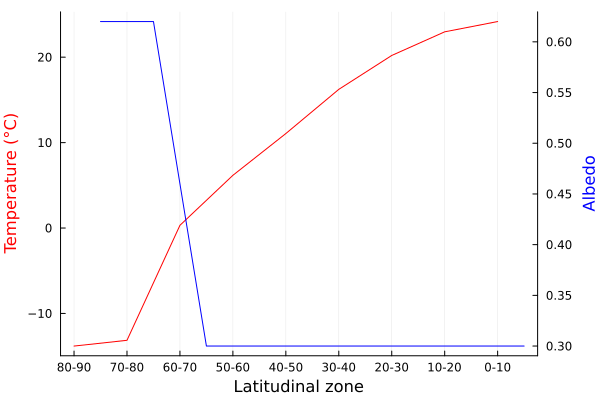

In [74]:
plot(
    output[:, :zone], output[:, :temp],
    ylab = "Temperature (°C)", xlab = "Latitudinal zone",
    color = "red", legend = false,
    yguidefontcolor = "red"
)
plot!(
    twinx(), output[:, :albedo],
    ylab = "Albedo",
    color = "blue", legend = false,
    yguidefontcolor = "blue"
)

## Transition to snowball Earth

We're interested in how the Earth's ice coverage responds to changes in insolation. This represents shifts in the orbital regime. Let's run the model for different levels of insolation. We can also see if the initial condition of the Earth (blue or snowball) affects where the transition point occurs.

In [100]:
# Define the critical temperature.
t_crit = -10.0
# Start everywhere above the critical temperature (blue Earth)
init_t_blue = repeat([t_crit + 1], 9)
# Start everywhere below the critical temperature (snowball Earth)
init_t_snowball = repeat([t_crit - 1], 9)
# Define a range of solar insolation fractions.
frac_sc_range = 0.5:0.1:1.5
# Define a structure to hold the results.
results = DataFrame(
    insolation = frac_sc_range,
    blue_mean_a = 0.0,
    snowball_mean_a = 0.0
)
# Examine a range of critical temperatures.
for (i, frac_sc) in enumerate(frac_sc_range)
    # Run the models.
    out_blue = find_equilibrium(init_t_blue, t_crit, frac_sc = frac_sc)
    out_snowball = find_equilibrium(init_t_snowball, t_crit, frac_sc = frac_sc)
    # Store the results.
    results[i, :blue_mean_a] = mean(out_blue[:, :albedo])
    results[i, :snowball_mean_a] = mean(out_snowball[:, :albedo])
end

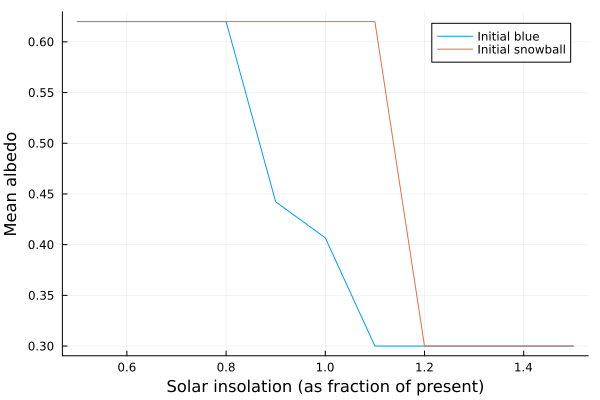

In [101]:
plot(
    results[:, :insolation], Matrix(results[:, 2:3]),
    ylab = "Mean albedo", xlab = "Solar insolation (as fraction of present)",
    labels = ["Initial blue" "Initial snowball"]
)

Looks like the Earth can remain blue for levels of insolation 0.8-1.2 times the current levels -- but only when the initial state is blue. We can tell from looking at this plot that for values of insolation in this range, the Earth has two stable states depending on the levels of ice coverage when the orbital regime shifts.